# Problem Statement
In this Jupyter Notebook, we will apply a K-Means Clustering algorithm on the output of a Classification and/or Regression algorithm. 
We will start with a small "proof-of-concept", where we apply K-Means clustering on the test data generated from a Wine dataset.
The purpose of this research is to investigate which errors occur disproportionately more in clusters comprising instances with demographic attributes, such as age, gender and income. This could indicate that the classification/regression algorithm underperforms for these groups, hereby indicating discriminating behaviour.

Furthermore, this study is inspired by the following paper: https://bit.ly/3g2pAmT (the Bias-Aware Hierarchical K-Means Clustering algorithm). 

### 1. Preprocessing the dataset
We start with creating the dataset through applying a classification or regression algorithm on the data to generate the desired input for the clustering analysis. 
Our input for the clustering algorithm has the following components:
- The test data in a Pandas DataFrame: the instances with their features 
- The ground truth labels (for a classification model) or values (for a regression model)
- The predicted classes/values per instance
- The errors of the model per instance, which can be calculated from (truth label - predicted label)


### Step 2: Applying the Classification/Regression Algorithm 
We apply a simple classification model on the data to obtain the classification errors. Then, we add the errors as attribute to the dataset. Here, we use the RandomForestClassifier algorithm from SciKit. 


### Step 3. Applying the K-Means Clustering
The third step is to apply K-Means Clustering on this dataset to eventually group similar errors into clusters. The cluster with the highest error rate will then be further investigated. We will first use the Elbow Method and the Silhouette Coefficient to select the number of clusters. 

### Step 4: Bias-Aware Hierarchical K-Means 
Finally, we formulate a bias metric to calculate the bias per cluster and to identify the cluster(s) with the highest bias. Then, we will adapt this bias detection algorithm to further identify bias in the clusters.



# 1. Preprocessing the dataset
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
# Splitting data into attribute columns and target column
df_data = pd.DataFrame(data.data, columns=data.feature_names)
df_target = pd.DataFrame(data = data.target)

# Merging the datasets into one dataframe
all_data = df_data.merge(df_target, left_index=True, right_index=True)

In [3]:
all_data.rename( columns={0 :'target_class'}, inplace=True )
all_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


## 1a. Data exploration

In [4]:
## Exploring the statistics of the dataset
all_data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target_class
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


The dataset does not require cleaning, as there are no missing values. 
If there would be missing values: --> imputation with mean values.

## Data Visualisation

<AxesSubplot:xlabel='proline', ylabel='proanthocyanins'>

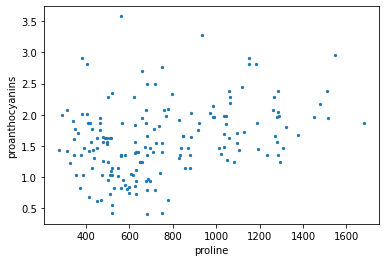

In [5]:
# Plotting with Pandas
all_data.plot.scatter(x='proline', y='proanthocyanins', s=5)


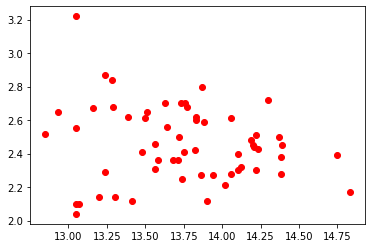

In [6]:
# Plotting with Matplotlib
all_data_class0 = all_data[all_data['target_class'] == 0] 
all_data_class1 = all_data[all_data['target_class'] == 1]
all_data_class2 = all_data[all_data['target_class'] == 2]


plt.plot(all_data_class0['alcohol'], all_data_class0['ash'], 'ro')
# plt.plot(all_data_class1[1], all_data_class1[2], 'ro', c='blue')
# plt.plot(all_data_class2[1], all_data_class2[2], 'ro', c='green')

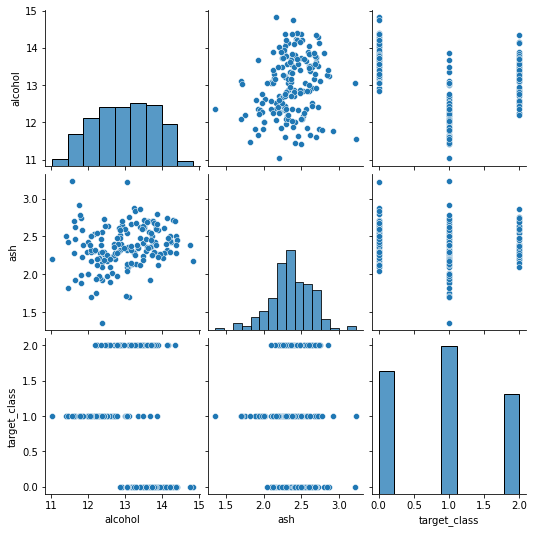

In [7]:
#Plotting with Seaborn
# sns.pairplot(all_data[[sns.pairplot(all_data[['alcohol','ash','target_class']], hue='target_class', palette=sns.color_palette("tab10")[:3])]])
X = all_data[['alcohol','ash','target_class']]
sns.pairplot(X)
# Hue: geeft de kleuren weer. Dus elke class is een eigen kleur en deze wordt geplot met elke andere feature in de dataset

## 2. Applying the Classification Algorithm (Random Forest)

In [8]:
# Dividing X and y into train and test data (small train data to gain more errors)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.50, random_state=2)

# Training a RandomForest Classifier 
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Obtaining predictions
y_hat = model.predict(X_test)

# Printing confusion matrix
# TODO confusion_matrix(X_test, y_hat)

<ipython-input-8-4de0e8583f23>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [9]:

# Converting y_hat from Np to DF
predictions_col = pd.DataFrame()
predictions_col['predicted_class'] = y_hat.tolist()
predictions_col['true_class'] = y_test

# Calculating the errors with the absolute value 
predictions_col['errors'] = abs(predictions_col['true_class'] - predictions_col['predicted_class'])

# Rescaling the prediction errors with max error value of 1
predictions_col['errors'] = predictions_col['errors'].replace(2.0, 1.0)

# Adding predictions to test data
df_out = pd.merge(X_test, predictions_col, left_index = True, right_index = True)

# TODO evt predicted, true class en errors droppen

# Evaluating the dataset
df_out


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,predicted_class,true_class,errors
12,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0,0.0,0.0
23,12.85,1.60,2.52,17.8,95.0,2.48,2.37,0.26,1.46,3.93,1.09,3.63,1015.0,1,0.0,1.0
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,0,0.0,0.0
35,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0,1,0.0,1.0
13,14.75,1.73,2.39,11.4,91.0,3.10,3.69,0.43,2.81,5.40,1.25,2.73,1150.0,2,0.0,1.0
65,12.37,1.21,2.56,18.1,98.0,2.42,2.65,0.37,2.08,4.60,1.19,2.30,678.0,0,1.0,1.0
48,14.10,2.02,2.40,18.8,103.0,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060.0,2,0.0,1.0
78,12.33,0.99,1.95,14.8,136.0,1.90,1.85,0.35,2.76,3.40,1.06,2.31,750.0,1,1.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,0.0,0.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,1,0.0,1.0


# 3. Clustering 
Sources:

- https://www.youtube.com/watch?v=ZueoXMgCd1c&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=35&ab_channel=sentdex
- https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca
- https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/?# 

## K-Means Clustering
K is the hyperparameter that defines how many clusters there will be formed in the cluster space. When you take K=2, then the data will be grouped into two clusters. 
When we have k=2, we have two centroids. We calculate the distance between the datapoints and the centroids. We assign each datapoint to the centroid that is closest. 
The centroids are randomly chosen and we classify the datapoints as being part of either cluster 1 or cluster 2. 
Then, we calculate the mean of all datapoints in cluster 1 and cluster 2 and we define the new centroid. 
Once the centroids are not moving anymore, we have the final centroids.
We also have a tolerance and a max_iteration parameter. 

Downside K-means: 
* It clusters the data in groups of roughly the same size. So you can't have three clusters in different sizes.
* Scaling 

Clustering is mostly used to find a certain pattern in the data rather than accuracy or visualisation purposes. 


In [10]:
# Importing clustering-relevant libraries
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

In [11]:
# Checking whether the SciKit KMeans is applicable on the PD Dataframe
# source: https://stackoverflow.com/questions/28017091/will-pandas-dataframe-object-work-with-sklearn-kmeans-clustering 

# Converting df to matrix 
matrix_form = df_out.values
df_matrix = matrix_form # should I transpose this? Then i'd get a list per feature 
print (df_matrix) 

[[1.375e+01 1.730e+00 2.410e+00 1.600e+01 8.900e+01 2.600e+00 2.760e+00
  2.900e-01 1.810e+00 5.600e+00 1.150e+00 2.900e+00 1.320e+03 0.000e+00
  0.000e+00 0.000e+00]
 [1.285e+01 1.600e+00 2.520e+00 1.780e+01 9.500e+01 2.480e+00 2.370e+00
  2.600e-01 1.460e+00 3.930e+00 1.090e+00 3.630e+00 1.015e+03 1.000e+00
  0.000e+00 1.000e+00]
 [1.305e+01 2.050e+00 3.220e+00 2.500e+01 1.240e+02 2.630e+00 2.680e+00
  4.700e-01 1.920e+00 3.580e+00 1.130e+00 3.200e+00 8.300e+02 0.000e+00
  0.000e+00 0.000e+00]
 [1.348e+01 1.810e+00 2.410e+00 2.050e+01 1.000e+02 2.700e+00 2.980e+00
  2.600e-01 1.860e+00 5.100e+00 1.040e+00 3.470e+00 9.200e+02 1.000e+00
  0.000e+00 1.000e+00]
 [1.475e+01 1.730e+00 2.390e+00 1.140e+01 9.100e+01 3.100e+00 3.690e+00
  4.300e-01 2.810e+00 5.400e+00 1.250e+00 2.730e+00 1.150e+03 2.000e+00
  0.000e+00 1.000e+00]
 [1.237e+01 1.210e+00 2.560e+00 1.810e+01 9.800e+01 2.420e+00 2.650e+00
  3.700e-01 2.080e+00 4.600e+00 1.190e+00 2.300e+00 6.780e+02 0.000e+00
  1.000e+00 1.000e+00

### Should we now rescale all the features? This is usually a preprocessing step for clustering

potential helpful source:
https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering

In [12]:
# Scaling the dataset

# checking the difference in the avg euclidean distance metrics when applying/ 
print('average euclidean distance of non-scaled features:', np.mean(euclidean_distances(df_matrix))) # 
print('average euclidean distance of scaled features:', np.mean(euclidean_distances(StandardScaler().fit_transform(df_matrix))))

# proceeding with scaled features
scaled_matrix = StandardScaler().fit_transform(df_matrix)
scaled_matrix

average euclidean distance of non-scaled features: 369.4246102943432
average euclidean distance of scaled features: 5.33680809166961


array([[ 3.63111822e-01, -1.79803290e-01,  3.32692163e-02,
        -4.81281612e-01, -1.18397197e+00, -2.03446490e-01,
         7.43175305e-02, -3.02579132e-01, -2.29715668e-02,
         5.53545758e-01,  4.38390995e-01, -2.84238018e-01,
         1.08764591e+00, -1.17536011e+00, -5.97614305e-01,
        -1.30930734e+00],
       [-9.25106468e-01, -3.63701479e-01,  3.72452933e-01,
         9.62563223e-02, -6.94052535e-01, -4.77918677e-01,
        -5.24261709e-01, -7.33754396e-01, -6.59475398e-01,
        -6.66600605e-01, -2.22225850e-02,  1.26179387e+00,
         1.43743544e-01, -3.01374387e-02, -5.97614305e-01,
         7.63762616e-01],
       [-6.38835737e-01,  2.72869175e-01,  2.53089477e+00,
         2.40640806e+00,  1.67389141e+00, -1.34828443e-01,
        -4.84679547e-02,  2.28447245e+00,  1.77072494e-01,
        -9.22319903e-01,  2.84853135e-01,  3.51117552e-01,
        -4.28787398e-01, -1.17536011e+00, -5.97614305e-01,
        -1.30930734e+00],
       [-2.33536649e-02, -6.66351738e

### Scaling the features results in weird values for the error columns.. How can I check whether they still make sense?

--> I could maybe use the MinMaxScaler instead of the StandardScaler?
"An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved using MinMaxScaler or MaxAbsScaler, respectively.

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data."

source: https://scikit-learn.org/stable/modules/preprocessing.html

 _"You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution."_



In [13]:
# Applying K-Means
# Fitting the model with the K-Means++ initialization, which has a faster convergence 
kmeans = KMeans(init="k-means++", n_clusters=2)
clus_model = kmeans.fit(scaled_matrix)
print('Cluster summary: ')
print('The lowest found SSE value for k=2: ', clus_model.inertia_)
print('The locations of the centroids are: ', clus_model.cluster_centers_)
print('The number of iterations required to converge:', clus_model.n_iter_)
print('The cluster assignments: ', clus_model.labels_)



Cluster summary: 
The lowest found SSE value for k=2:  448.0339514353803
The locations of the centroids are:  [[ 0.40247405  0.12484124  0.26783458 -0.05156589  0.1137313   0.32017456
   0.36483676 -0.14858797  0.17512401  0.39672198 -0.24978763  0.30800414
   0.48936213 -0.15283987 -0.5976143  -0.12469594]
 [-1.12692733 -0.34955546 -0.74993682  0.14438448 -0.31844763 -0.89648876
  -1.02154292  0.41604631 -0.49034724 -1.11082156  0.69940536 -0.86241159
  -1.37021395  0.42795163  1.67332005  0.34914862]]
The number of iterations required to converge: 8
The cluster assignments:  [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0
 1]


## Evaluating the Clustering performance
## Choosing the right numbers of clusters
### The Elbow Method
With this method, we plot the SSE as a function of the number of clusters.
With the elbow elbow method and the silhouette coefficient, we can evaluate the clustering performance without ground truth labels. 

In [14]:
# Making a dictionary of the K-means arguments
clus_model_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


# A list holding the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **clus_model_kwargs)
    kmeans.fit(scaled_matrix)
    sse.append(kmeans.inertia_)

We can now plot the Elbow point, which is the location in the plot where the SSE bends down slightly. This point indicates a trade-off between the errors and the number of clusters. In the plot below, we can observe that the elbow point is located at [k=2, SSE=450]

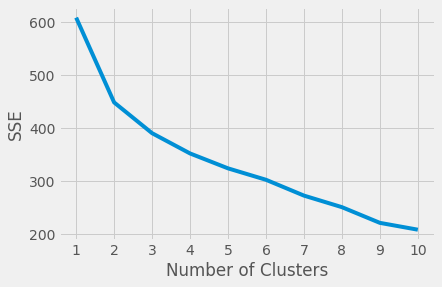

In [15]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

To confirm our observation, we can calculate the Elbow point programmatically with kneed.

In [16]:
from kneed.knee_locator import *
kl = kneed.KneeLocator(range(1, 11), sse, curve="convex", direction ="decreasing")
kl.elbow

NameError: name 'kneed' is not defined

### ? Here, the elbow point is 3 instead of 2. How to decide which one to pick? 



## The Silhouette Coefficient

This method quantifies how well a data points fits into its assigned cluster based on the following two factors:
* The mean intra-cluster distance --> a
* The mean nearest-cluster distance --> b
For each instance in the dataset:
(b-a)/max(a, b)



In [17]:
# A list holding the silhouette coefficients for each k
silhouette_coefficients = []

# Starting with 2 cluster (which is the minimum)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **clus_model_kwargs)
    kmeans.fit(scaled_matrix)
    score = silhouette_score(scaled_matrix, kmeans.labels_)
    silhouette_coefficients.append(score)

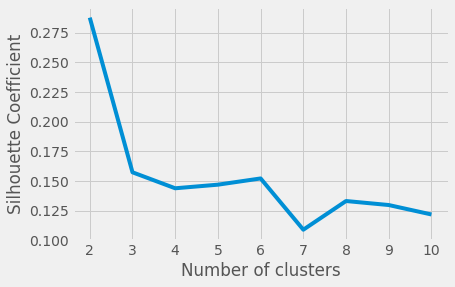

In [18]:
# Plotting the avg silhouette score for each k 
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Following from this, we can best proceed with k = 2. The higher the silhouette coefficient is, the more likely it is that an instance is accurately assigned to its cluster. 


## 3. Clustering Evaluation with ground truth labels 

In [ ]:
# Adjusted Rand Index?
# metrics.rand_score(labels_true, labels_pred)



## 4. The Bias-Aware Hierarchical Clustering Algorithm

- Bias Metric: the negative Bias
definition: 
Total group of users = Ub

B_{b} = Metric()

In [19]:
scaled_matrix;

In [39]:
calculate_bias(df_out)

<ipython-input-38-636395425443>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_pos = cluster[cluster["true_class"] == class_number][cluster["predicted_class"] == class_number]
<ipython-input-38-636395425443>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_neg = cluster[cluster["true_class"] != class_number][cluster["predicted_class"] != class_number]
<ipython-input-38-636395425443>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_pos = cluster[cluster["true_class"] != class_number][cluster["predicted_class"] == class_number]
<ipython-input-38-636395425443>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_neg = cluster[cluster["true_class"] == class_number][cluster["predicted_class"] != class_number]
<ipython-input-38-636395425443>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_pos = cluster[cluste

ZeroDivisionError: division by zero

In [38]:
# alles met cluster vervangen door class
def F_score(cluster, class_number):
    true_pos = cluster[cluster["true_class"] == class_number][cluster["predicted_class"] == class_number]
    true_neg = cluster[cluster["true_class"] != class_number][cluster["predicted_class"] != class_number]
    false_pos = cluster[cluster["true_class"] != class_number][cluster["predicted_class"] == class_number]
    false_neg = cluster[cluster["true_class"] == class_number][cluster["predicted_class"] != class_number]

    precision =  len(true_pos)/(len(true_pos) + len(false_pos))
    recall = len(true_pos)/(len(true_pos) + len(false_neg))
    f_score = 2 * ((precision * recall)/(precision + recall))

    return f_score

# Calculating the bias
def calculate_bias(cluster):
    cluster_0 = F_score(cluster, 0)
    cluster_1 = F_score(cluster, 1)

    cluster_list = []
    
    for i in range(0,3):
        cluster_list.append(F_score(cluster, i))

    mean_F_score = cluster_list.sum()/3 
    
    return(mean_F_score)
    
#calculate_bias(df_out)
# df_out[df_out["true_class"] == 0][df_out["predicted_class"] == 0]

In [279]:
# Setting the max_iterations
MAX_ITER = 5 # --> in each iteration we split on the cluster with the highest standard deviation
cluster_list = []

# start with all instances in one clusters
df_matrix

for i in range(1, MAX_ITER):
    name_x = KMeans(n_clusters=2, **clus_model_kwargs)
    name_x  .fit(scaled_matrix)

    # Calculating the bias per cluster
    # Should I add each cluster in a list?
    # cluster_list.append(cluster)
    bias = f-score




NameError: name 'f' is not defined